# 🧹 Data Quality Analysis & Cleaning

> **PM Accelerator Mission**: "By making industry-leading tools and education available to individuals from all backgrounds, we level the playing field for future PM leaders."

---

## Objectives
1. Load and examine raw GlobalWeatherRepository data
2. Identify and fix data quality issues
3. Clean and standardize the dataset
4. Output a cleaned CSV for use in other analyses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
print('✅ Libraries loaded!')

✅ Libraries loaded!


In [2]:
# Load raw data
RAW_PATH = Path('../../data/raw/GlobalWeatherRepository.csv')
OUTPUT_PATH = Path('../data/weather_cleaned.csv')

df = pd.read_csv(RAW_PATH)
print(f'📊 Original Dataset: {len(df):,} rows × {df.shape[1]} columns')
df.head()

📊 Original Dataset: 114,203 rows × 41 columns


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


---
## 🌍 Issue 1: Country Name Problems

### 1.1 Low-Frequency Countries (Potential Typos)

In [3]:
country_counts = df['country'].value_counts()
low_freq = country_counts[country_counts < 100].sort_values()

print(f'⚠️ Found {len(low_freq)} low-frequency countries (< 100 records):')
for name, count in low_freq.items():
    print(f'  {name}: {count} records')

⚠️ Found 25 low-frequency countries (< 100 records):
  Lao People's Democratic Republic: 1 records
  Libya: 1 records
  Kosovo: 1 records
  Togo: 1 records
  Komoren: 1 records
  Malásia: 1 records
  كولومبيا: 1 records
  Colombia: 1 records
  Inde: 1 records
  Estonie: 1 records
  Гватемала: 1 records
  Letonia: 1 records
  Polônia: 1 records
  Mexique: 1 records
  Marrocos: 1 records
  Польша: 1 records
  Jemen: 1 records
  Турция: 1 records
  Saint-Vincent-et-les-Grenadines: 1 records
  Südkorea: 1 records
  Saudi Arabien: 1 records
  Bélgica: 1 records
  Turkménistan: 1 records
  火鸡: 1 records
  USA United States of America: 3 records


### 1.2 Non-ASCII Country Names

In [4]:
# Find non-ASCII country names
def is_non_ascii(s):
    return any(ord(c) > 127 for c in str(s))

non_ascii = [(name, count) for name, count in country_counts.items() if is_non_ascii(name)]
print(f'⚠️ Found {len(non_ascii)} countries with non-ASCII characters:')
for name, count in non_ascii:
    print(f'  {name}: {count} records')

⚠️ Found 10 countries with non-ASCII characters:
  Malásia: 1 records
  كولومبيا: 1 records
  Гватемала: 1 records
  Polônia: 1 records
  Польша: 1 records
  Турция: 1 records
  Südkorea: 1 records
  Bélgica: 1 records
  Turkménistan: 1 records
  火鸡: 1 records


### 1.3 Country Name Cleaning Map

In [5]:
# Define country name fixes
COUNTRY_FIXES = {
    'Verenigde Staten': 'United States of America',
    'Alemania': 'Germany',
    'Australië': 'Australia',
    'Bélgica': 'Belgium',
    'Südkorea': 'South Korea',
    'Saudi Arabien': 'Saudi Arabia',
    'Turkménistan': 'Turkmenistan',
    '火鸡': 'Turkey',  # Chinese for Turkey
    'USA United States of America': 'United States of America',
    'Saint-Vincent-et-les-Grenadines': 'Saint Vincent and the Grenadines',
    'Guinéée-Bissau': 'Guinea-Bissau',
    'Panamá': 'Panama',
    'Países Bajos': 'Netherlands',
    'Émirats Arabes Unis': 'United Arab Emirates',
    'Côte d\'Ivoire': 'Ivory Coast',
    'ประเทศไทย': 'Thailand',
    '日本': 'Japan',
    '中国': 'China',
    'भारत': 'India',
    'مصر': 'Egypt'
}

print(f'📝 Defined {len(COUNTRY_FIXES)} country name fixes')

📝 Defined 20 country name fixes


In [6]:
# Apply fixes
df_clean = df.copy()
df_clean['country'] = df_clean['country'].replace(COUNTRY_FIXES)

print('✅ Country fixes applied!')
print(f'Before: {df["country"].nunique()} unique countries')
print(f'After: {df_clean["country"].nunique()} unique countries')

✅ Country fixes applied!
Before: 211 unique countries
After: 204 unique countries


---
## 🌤️ Issue 2: Condition Text Case Inconsistency

In [7]:
if 'condition_text' in df_clean.columns:
    conditions = df_clean['condition_text'].value_counts()
    print(f'📋 Unique conditions before: {len(conditions)}')
    
    # Standardize to Title Case
    df_clean['condition_text'] = df_clean['condition_text'].str.strip().str.title()
    
    print(f'✅ Conditions standardized')
    print(f'Unique conditions after: {df_clean["condition_text"].nunique()}')

📋 Unique conditions before: 47
✅ Conditions standardized
Unique conditions after: 46


---
## 📊 Issue 3: Missing Values

In [8]:
missing = df_clean.isnull().sum()
missing_pct = (missing / len(df_clean) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

missing_summary = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_summary) > 0:
    print('⚠️ Columns with missing values:')
    display(missing_summary)
else:
    print('✅ No missing values found!')

✅ No missing values found!


---
## 🔧 Issue 4: Date Parsing

In [9]:
# Parse date columns
date_cols = [col for col in df_clean.columns if 'date' in col.lower() or 'updated' in col.lower()]

for col in date_cols:
    if col in df_clean.columns:
        try:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
            print(f'✅ Parsed {col} as datetime')
        except:
            print(f'⚠️ Could not parse {col}')

# Create a simple 'date' column if needed
if 'last_updated' in df_clean.columns:
    df_clean['date'] = pd.to_datetime(df_clean['last_updated']).dt.date
    print('✅ Created date column from last_updated')

✅ Parsed last_updated_epoch as datetime
✅ Parsed last_updated as datetime
✅ Created date column from last_updated


---
## 📊 Data Quality Visualizations

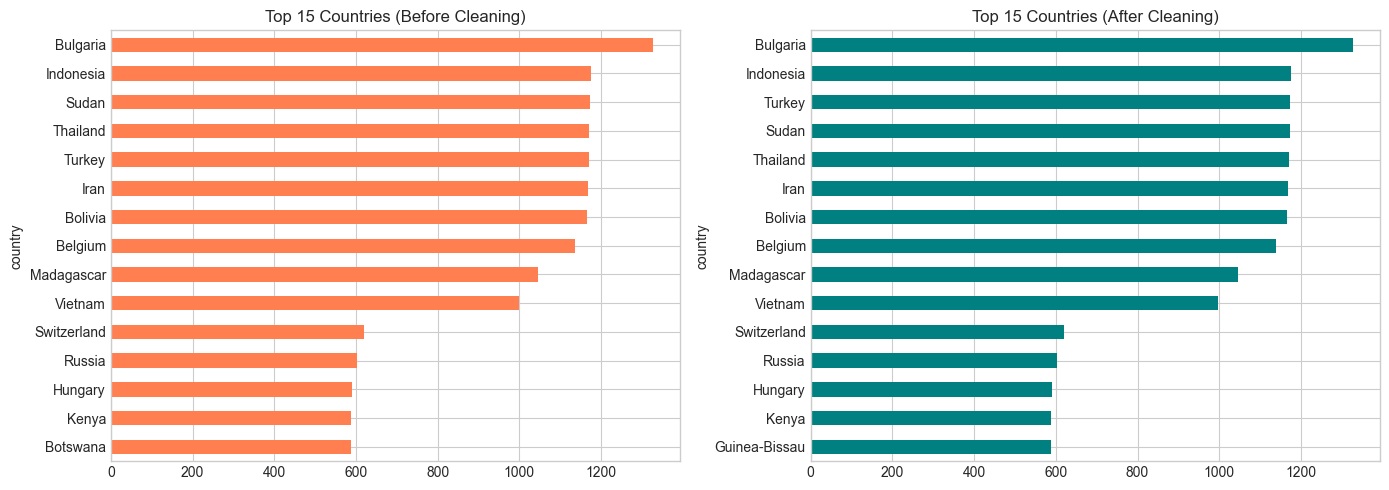

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before vs After country distribution
df['country'].value_counts().head(15).plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_title('Top 15 Countries (Before Cleaning)')
axes[0].invert_yaxis()

df_clean['country'].value_counts().head(15).plot(kind='barh', ax=axes[1], color='teal')
axes[1].set_title('Top 15 Countries (After Cleaning)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

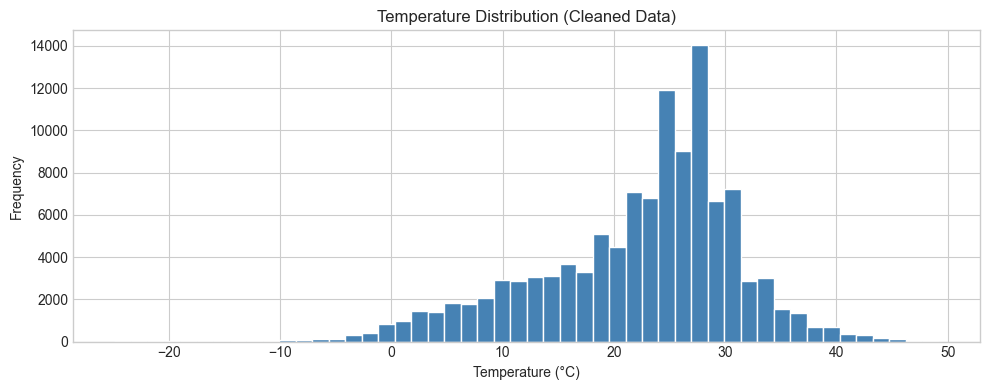

In [11]:
# Temperature distribution
if 'temperature_celsius' in df_clean.columns:
    fig, ax = plt.subplots(figsize=(10, 4))
    df_clean['temperature_celsius'].hist(bins=50, ax=ax, color='steelblue', edgecolor='white')
    ax.set_title('Temperature Distribution (Cleaned Data)')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

---
## 💾 Save Cleaned Dataset

In [12]:
# Final summary
print('='*60)
print('📊 CLEANED DATASET SUMMARY')
print('='*60)
print(f'Total Records: {len(df_clean):,}')
print(f'Total Columns: {df_clean.shape[1]}')
print(f'Countries: {df_clean["country"].nunique()}')
print(f'Date Range: {df_clean["date"].min()} to {df_clean["date"].max()}')
print('='*60)

📊 CLEANED DATASET SUMMARY
Total Records: 114,203
Total Columns: 42
Countries: 204
Date Range: 2024-05-16 to 2025-12-24


In [13]:
# Save cleaned data
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_clean.to_csv(OUTPUT_PATH, index=False)
print(f'✅ Cleaned dataset saved to: {OUTPUT_PATH}')
print(f'   Size: {OUTPUT_PATH.stat().st_size / 1024 / 1024:.1f} MB')

✅ Cleaned dataset saved to: ..\data\weather_cleaned.csv
   Size: 32.5 MB
